In [1]:
import requests
from bs4 import BeautifulSoup
import concurrent.futures
import numpy as np
import pandas as pd
import seaborn as sns
import regex as re
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression,LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")

C:\Users\Admin\AppData\Local\Temp\ipykernel_17672\4019083629.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# **WEB SCRAPING**

Lấy đường link từng trang của web (take the websites' links)

In [ ]:
list_of_links = []
for i in range(450):
  number = str(i+1)
  list_of_links.append('https://batdongsan.vn/ban-nha/p' + number)

Lấy đường link các bài đăng rao bán nhà (Get the link of the house for sale)

In [ ]:
house_info = []
for link in list_of_links:
  response = requests.get(link)
  html_content = response.text
  soup = BeautifulSoup(html_content, 'html.parser')
  links = soup.findAll('div',  {'class':'name'})
  number = len(links)
  for i in range(number):
    house_info.append(links[i].find('a').get('href'))
  del house_info[-5:]
house_info

Lấy thông tin chi tiết của từng bài viết, sử dụng đa luồng để có thể request nhanh hơn (Get detailed information of each article, use multi-threading to be able to request faster)

In [ ]:
house_details = []
def get_details(url):
    resp = requests.get(url=url)
    html_content = resp.text
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup

urls = house_info

with concurrent.futures.ThreadPoolExecutor() as executor:

    futures = []

    for url in urls:
        futures.append(executor.submit(get_details, url=url))

    for future in concurrent.futures.as_completed(futures):
        house_details.append(future.result())

Lưu từng bài đăng từ dạng HTML sang file *.txt để tiện xử lý sau này (không phải request lại) (Save each post from HTML to *.txt file for later processing (no re-request)

In [ ]:
num = 1
for i in house_details:
    with open('House' + str(num) + '.txt', 'a+', encoding='utf-8') as f:
        f.write(str(i))
    num = num+1

# **DATA EXTRACTION**

## **Xử lý bước đầu (Initial processing)**

In [ ]:
gia = []
ten = []
dt = []
dc = []
quan = []
phongngu = []
thoigian = []
num = 1
for i in range (9000):
    temp = []
    if num == 2395 or num == 3641 or num == 3669 or num == 3824:
        num = num + 1
        continue
    #đọc từng file txt để trích xuất các thông tin cần thiết
    with open('D:\data2\House'+ str(num) + '.txt','r',encoding='utf-8') as f:
        soup = BeautifulSoup(f, "html.parser")
        gia.append(soup.find('strong', {'class':'price'}).text.strip())
        ten.append(soup.find('title').text.strip())
        dtdc = soup.find('div', {'class':'param'}).text.strip()
        temp = soup.find('ul',{'class':'uk-breadcrumb'}).text
        temp = temp.split('\n')
        dt.append(dtdc.split('\n')[0].split('Diện tích:')[-1].strip())
        dc.append(temp[3])
        quan.append(temp[4])
        thoigian.append(soup.find('time',{'class':'timeago'})['datetime'])
        if len(dtdc.split('\n')) < 3:
            phongngu.append(np.nan)
        else:
            phongngu.append(dtdc.split('\n')[1].split('Phòng ngủ:')[-1].strip())
        num = num+1

In [ ]:
house = pd.DataFrame(
    {'Tên': ten,
     'Giá': gia,
     'Diện tích': dt,
     'Phòng ngủ': phongngu,
     'Thành phố': dc,
     'Quận/Huyện': quan,
     'Ngày đăng': thoigian})

In [ ]:
house["Diện tích"] = house["Diện tích"].str.replace(' m2','')
house["Diện tích"] = house["Diện tích"].str.replace('Phòng.*','', regex=True)
house["Diện tích"] = house["Diện tích"].str.replace('Địa chỉ.*','', regex=True)
house["Diện tích"] = house["Diện tích"].str.replace('Hướng.*','', regex=True)

In [ ]:
house["Giá"] = house["Giá"].str.replace(' triệu','000000')
house["Giá"] = house["Giá"].str.replace(' tỷ','')
house["Giá"] = house["Giá"].str.replace('Thỏa.*','0', regex=True)

In [ ]:
house["Phòng ngủ"] = house["Phòng ngủ"].str.replace(' PN','')
house["Phòng ngủ"] = house["Phòng ngủ"].str.replace('Hướng.*','0', regex=True)
house["Phòng ngủ"] = house["Phòng ngủ"].str.replace('Phòng.*','0', regex=True)

In [ ]:
house.to_csv('HouseInVietNam.csv',index=False,header =True,encoding='utf-8-sig')

## **Xử lý chi tiết (Processing details)**

Xử lý dữ liệu giá nhà (Processing house price data)

In [ ]:
house = pd.read_csv('/content/HouseInVietNam.csv')

In [ ]:
house["Giá"] = house["Giá"].str.replace("nghìn","")
house['Giá'] = house['Giá'].astype(float)
house = house.replace(0,np.nan)

In [ ]:
#Lấy giá nhà theo đơn vị tỷ và triệu từ mô tả trong cột
b_price_list = []
m_price_list = []

#Lấy giá nhà theo đơn vị triệu/m2
per_m2_list = []

for description in house["Tên"]:
  b_price = re.search(r'((\d+(,|.)\d+)|(\d+))\s*(?=tỷ|Tỷ|xtỷ|xxx Tỷ|tyxx|tỉ|Tỉ)',description)
  m_price = re.search(r'\d+\s*(?=Triệu|triệu|tr)',description)
  per_m2_price = re.search(r'\d+\s*(?=Triệu(\/)m2|triệu(\/)m2|tr(\/)m2|TRIỆU(\/)M2|TRIỆU(\/)2|tr(\/)m)', description)
  if(b_price == None):
    b_price_list.append(0)
  else:
    b_price_list.append(b_price.group())
  if(m_price == None):
    m_price_list.append(0)
  else:
    m_price_list.append(m_price.group())
  if(per_m2_price == None):
    per_m2_list.append(0)
  else:
    per_m2_list.append(float(per_m2_price.group()))


for i in range(len(b_price_list)):
  if (type(b_price_list[i]) == str):
    if("/" in b_price_list[i]):
      b_price_list[i] = b_price_list[i].split("/")[1]
    b_price_list[i] = "".join(b_price_list[i].split())
    b_price_list[i] = b_price_list[i].replace(',','.')
  b_price_list[i] = float(b_price_list[i])
  m_price_list[i] = float(m_price_list[i])
  b_price_list[i] += m_price_list[i]/1000

In [ ]:
#Lấy các giá từ miêu tả để thay thế giá
for i in range(len(house["Giá"])):
  if(per_m2_list[i]!=0):
    house["Giá"][i] = per_m2_list[i] * house["Diện tích"][i]
  elif(b_price_list[i] != 0):
    house["Giá"][i] = b_price_list[i]

#Nếu không lấy được từ mô tả thì sẽ xử lý thủ công để đưa về giá trị ở đơn vị tỷ
for i in range(len(house["Giá"])):
  if (np.isnan(house["Giá"][i]) != True):
    if(house["Giá"][i] >= 1e9):
      house["Giá"][i] /= 1e9
    elif(house["Giá"][i] >= 1e6):
      house["Giá"][i] /= 1e7
    elif(house["Giá"][i] >= 1e5):
      house["Giá"][i] /= 1e5
    elif(house["Giá"][i] >= 1e4):
      house["Giá"][i] /= 1e4
    elif(house["Giá"][i] >= 1e3):
      house["Giá"][i] /= 1e3
    elif(house["Giá"][i] >= 1e2):
      house["Giá"][i] /= 1e2


Xử lý dữ liệu diện tích (Processing house area)

In [ ]:
area_list = []
for description_1, description_2 in zip(house["Mô tả"],house["Tên"]):
  area = re.search(r'(((\d+(,|\.)\d+)|(\d+))\s*)(?=m2|M2|m²)',description_1 + description_2)
  if(area == None):
    area_list.append(np.nan)
  else:
    area_list.append(area.group().replace(",","."))

In [ ]:
for i in range(len(house["Diện tích"])):
  if(np.isnan(house["Diện tích"][i])):
    house["Diện tích"][i] = area_list[i]
  else:
    continue


Xử lý dữ liệu phòng ngủ (Processing numbers of bedrooms)

In [ ]:
bed_rooms = []
for description in house["Mô tả"]:
  room = re.findall(r'\d\s*(?=PN|ngủ|pn|phòng ngủ|Phòng Ngủ|Pn|Phòng ngủ)',description)
  room = list(map(int,room))
  result = sum(room)
  bed_rooms.append(result)


In [ ]:
for i in range(len(house["Phòng ngủ"])):
  if(np.isnan(house["Phòng ngủ"][i])):
    house["Phòng ngủ"][i] = bed_rooms[i]
  else:
    continue

Sử dụng mô hình hồi quy tuyến tính điền giá trị bị thiếu ở cột diện tích (Using a linear regression model fill in the missing value in the area column)

In [ ]:
missing_data = house[house['Diện tích'].isnull()]

# Lọc các giá trị đầy trong cột "Diện tích" và "Phòng ngủ"
known_data = house.dropna(subset=['Diện tích', 'Phòng ngủ'])

lr = LinearRegression()
lr.fit(known_data['Phòng ngủ'].values.reshape(-1, 1), known_data['Diện tích'])
predicted_data = lr.predict(missing_data['Phòng ngủ'].values.reshape(-1, 1))

# Điền giá trị dự đoán vào cột "Diện tích" còn thiếu
house.loc[house['Diện tích'].isnull(), 'Diện tích'] = predicted_data

Sử dụng mô hình hồi quy tuyến tính điền giá trị bị thiếu ở cột giá (Using a linear regression model fill in the missing value in the price column)

In [ ]:
missing_data = house[house['Giá'].isnull()]

# Lọc các giá trị đầy trong cột "Diện tích" và "Phòng ngủ"
known_data = house.dropna(subset=['Giá', 'Diện tích'])

lr = LinearRegression()
lr.fit(known_data['Diện tích'].values.reshape(-1, 1), known_data['Giá'])
predicted_data = lr.predict(missing_data['Phòng ngủ'].values.reshape(-1, 1))

# Điền giá trị dự đoán vào cột "Diện tích" còn thiếu
house.loc[house['Giá'].isnull(), 'Giá'] = predicted_data

Thêm cột số tầng từ mô tả (Add floor number column from description)

In [ ]:
floor_list = []
for description in house["Mô tả"]:
  ground_floor = re.findall(r'\d+\s*(?=Trệt|Tầng trệt|tầng trệt)', description)
  floor = re.findall(r'\d+\s*(?=Lầu|Tầng|tầng|lầu)', description)
  if(len(ground_floor) == 0):
    ground_floor.append(0)
  if(len(floor) == 0):
    floor.append(0)
  floor = int(floor[0]) + int(ground_floor[0])
  if(floor != 0):
    floor_list.append(floor)
  else:
    floor_list.append(1)

house["Số tầng"] = floor_list


Thêm cột tiện ích cho từng ngôi nhà (Add score column)

In [ ]:
house['Score'] = 0.0
for i in range (len(house)):
  score = 0
  text = house.iloc[i]['Mô tả']
  lower_text = text.lower()
  if "mới" in lower_text:
    score += 1
  if "thang máy" in lower_text:
    score += 1
  if "hầm xe" in lower_text:
    score += 1
  if "an ninh" in lower_text:
    score += 1
  if "đẹp" in lower_text:
    score += 1
  if "mặt tiền" in lower_text:
    score += 1
  if "kinh doanh" in lower_text:
    score += 1
  if "hồ bơi" in lower_text:
    score += 1
  if "vườn" in lower_text:
    score += 1
  house['Score'][i] = score

Xử lí cột thời gian (Process time)

In [ ]:
house['Ngày đăng'] = [pd.Timestamp(time) for time  in house['Ngày đăng'] ]
house['Giờ'] = [house['Ngày đăng'][i].hour for i in range(len(house))]
house['Tháng'] = [house['Ngày đăng'][i].month for i in range(len(house))]
house['Ngày của tuần'] = [house['Ngày đăng'][i].day for i in range(len(house))]

Xử lý các outlier (Process outliers)

In [ ]:
house['Price per Square'] = house['Giá']/(house['Diện tích'].astype(float)*house['Số tầng'])
#Outlier detect
Q1 = house['Price per Square'].quantile(0.25)
Q3 = house['Price per Square'].quantile(0.75)
# Tính phạm vi IQR
IQR = Q3 - Q1
# Xác định giới hạn trên và dưới để xác định outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Xử lý outlier bằng cách thay thế bằng giới hạn trên và dưới
house = house[(house['Price per Square'] >= lower_bound) & (house['Price per Square'] <= upper_bound)].dropna()
house.reset_index(drop=True, inplace=True)

In [ ]:
house.to_csv('HouseInVietNam_finall.csv',index=False,header =True,encoding='utf-8-sig')

# **Data visualization**

Dữ liệu sau khi được xử lí (Data after processing)

In [2]:
house = pd.read_csv('HouseInVietNam.csv')

In [3]:
house

,Tên,Giá,Diện tích,Phòng ngủ,Thành phố,Quận/Huyện,Mô tả,Ngày đăng,Số tầng,Score,Price per Square,Giờ,Tháng,Ngày của tuần
0,"Bán Biệt thự sân vườn Quận 12, 130m2, 3 Tầng 7...",9.20,130.0,7.0,TP Hồ Chí Minh,Quận 12,"+ Kết cấu: 7 PN, 6 WC, ban công, phòng thờ, Ph...",2023-05-29 13:06:27,1,1.0,0.070769,13,5,29
1,Mới! Bán Nhà Trần Khát Chân – Lô Góc – Ô tô KD...,14.00,93.5,4.0,Hà Nội,Hai Bà Trưng,*HAI BÀ TRƯNG KHÔNG CÓ CĂN THỨ HAI!!!\n\n- Nhà...,2023-06-02 10:28:42,7,5.0,0.021390,10,6,2
2,Bán nhà 1 Trệt 1 Lầu thổ cư 72m2 đường ô tô (P...,3.57,72.0,4.0,Đồng Nai,Biên Hòa,????????GIẢM MẠN 430tr ( 4tỉ ????CÒN 3 tỉ 570 ...,2023-06-02 10:51:58,1,0.0,0.049583,10,6,2
3,"Bán nhà Trường Chinh, nhà mới tân trang đẹp lu...",5.10,42.0,4.0,Hà Nội,Thanh Xuân,- Nhà đẹp gần phố - đi lại thuận tiện – ba bướ...,2023-06-02 10:52:15,1,2.0,0.121429,10,6,2
4,"Nhà đẹp lung linh, hxh 6m, Thống Nhất P11 Gò V...",8.80,47.0,4.0,TP Hồ Chí Minh,Gò Vấp,"MS 13223\n\n* Nhà thiết kế hiện đại, đẹp như r...",2023-06-01 14:52:33,4,4.0,0.046809,14,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8433,SIÊU ĐẸP SIÊU HOT - NHÀ MỚI HOÀNG HOA THÁM - 3...,5.45,38.0,4.0,Hà Nội,Ba Đình,NHÀ ĐẸP MỚI Ở LUÔN - CHỦ NHÀ TẶNG 100% NỘI THẤ...,2022-11-01 10:06:39,1,2.0,0.143421,10,11,1
8434,"(VQ0074 ) 7.4 tỷ, Nhà Mặt Phố, ô Tô Tránh, Văn...",7.40,60.0,4.0,Hà Nội,Hà Đông,"(VQ0074 ) 7.4 tỷ, Nhà Mặt Phố, ô Tô Tránh, Văn...",2022-11-01 10:09:45,4,1.0,0.030833,10,11,1
8435,"Nội thất đẹp, Vũ Huy Tấn, 4.3 x 9.5, 2 lầu, 5....",5.80,40.0,3.0,TP Hồ Chí Minh,Bình Thạnh,"Nhà bán Vũ Huy Tấn, Phường 3, Quận Bình Thạnh....",2022-11-01 10:11:02,2,2.0,0.072500,10,11,1
8436,"Nhà Bình Thành,Bình Tân đường 5m diện tích 4mx...",3.35,34.0,2.0,TP Hồ Chí Minh,Bình Tân,"""Nhà Bình Thành,Bình Tân đường 5m diện tích 4m...",2022-11-01 10:13:18,2,2.0,0.049265,10,11,1


Biểu đồ nhiệt covariance giữa các feature (Heatmap)

<Axes: >

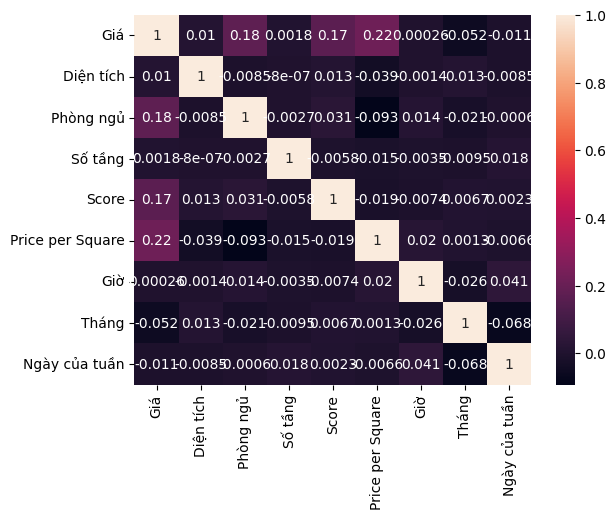

In [4]:
sns.heatmap(house.corr(numeric_only=True),annot = True)

Biểu đồ nhiệt giá nhà dựa vào vị trí sử dụng kernel density estimation (Heatmap using kernel density estimation)

<Axes: xlabel='Quận/Huyện', ylabel='Giá'>

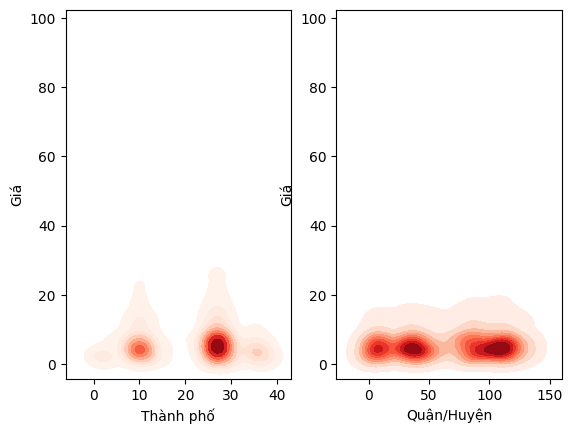

In [5]:
data_backup = house.copy()
lb = LabelEncoder()
data_backup.isetitem(data_backup.columns.get_loc('Thành phố'),lb.fit_transform(data_backup.loc[:,'Thành phố']))
data_backup.isetitem(data_backup.columns.get_loc('Quận/Huyện'),lb.fit_transform(data_backup.loc[:,'Quận/Huyện']))
plt.subplot(1, 2, 1)
sns.kdeplot(data=data_backup, x='Thành phố', y='Giá', cmap="Reds", thresh=0.05,fill=True)
plt.subplot(1, 2, 2)
sns.kdeplot(data=data_backup, x='Quận/Huyện', y='Giá', cmap="Reds", thresh=0.05,fill=True)

# **MODELING**

##**Data preprocessing**

In [6]:
features = ['Diện tích', 'Thành phố', 'Quận/Huyện','Score','Phòng ngủ', 'Giờ', 'Tháng','Ngày của tuần']
target = 'Giá'
X = house[features].to_numpy()
X = OrdinalEncoder().fit_transform(X)
y = house[target].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## **Linear regresion**

Linear Regression là một phương pháp thống kê để hồi quy dữ liệu với biến phụ thuộc có giá trị liên tục trong khi các biến độc lập có thể có một trong hai giá trị liên tục hoặc là giá trị phân loại. Nói cách khác "Hồi quy tuyến tính" là một phương pháp để dự đoán biến phụ thuộc (Y) dựa trên giá trị của biến độc lập (X).

Mô hình Linear Regression tìm kiếm một đường tuyến tính tốt nhất để mô phòng mối quan hệ giữa biến phụ thuộc và biến độc lập. Các tham số của mô hình được tìm thấy bằng phương pháp tối ưu, với mục tiêu là giảm thiểu sai số giữa dự đoán và giá trị thực tế. Kết quả là một mô hình đơn giản, dễ hiểu và dễ sử dụng, cung cấp khả năng dự đoán giá trị mới dựa trên các biến đầu vào đã biết trước.

In [7]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
mse_linearRegression = mean_squared_error(y_test, y_pred)
rmse_linearRegression = np.sqrt(mse_linearRegression)
R2_linear = linear_model.score(X_train,y_train)
print("MSE:", mse_linearRegression)
print("RMSE score for Linear Regression: {:.4f}".format(rmse_linearRegression))
print("R2-Score: ", linear_model.score(X_train, y_train))

MSE: 37.73876241540304
RMSE score for Linear Regression: 6.1432
R2-Score:  0.17995710417167698


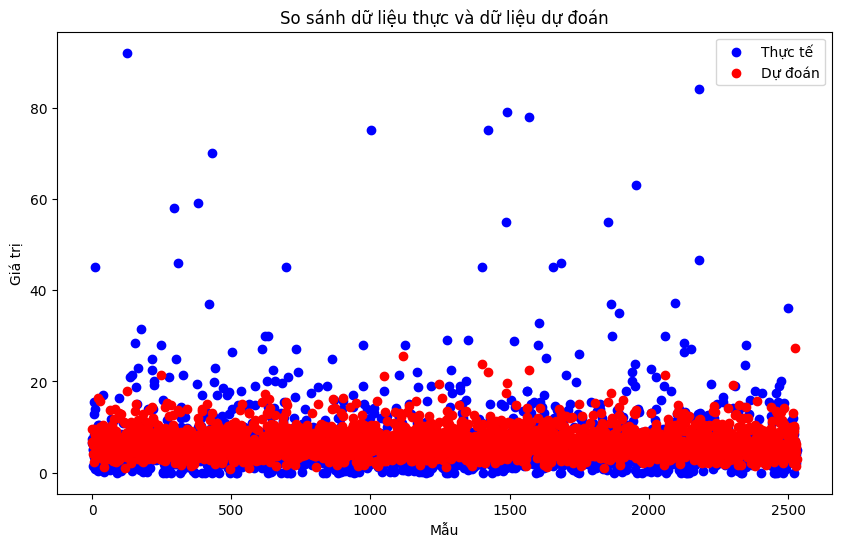

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Thực tế')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Dự đoán')
plt.xlabel('Mẫu')
plt.ylabel('Giá trị')
plt.title('So sánh dữ liệu thực và dữ liệu dự đoán')
plt.legend()
plt.show()

## **Lasso regression**

Mô hình Lasso Regression được sử dụng trong việc ước lượng và lựa chọn các biến quan trọng trong một mô hình hồi quy tuyến tính. Đặc trưng của mô hình này là việc áp dụng một quy tắc chặt chẽ để đưa ra ước lượng hệ số và loại bỏ những biến không quan trọng.

Thay vì tìm kiếm một mô hình tuyến tính hoàn hảo, Lasso Regression sử dụng một thành phần regularization để kiểm soát sự phức tạp của mô hình. Thành phần này được xây dựng dựa trên giá trị tuyệt đối của các hệ số, dẫn đến việc đặt một số hệ số bằng 0. Kết quả là một mô hình hồi quy tuyến tính thưa (sparse), chỉ chứa các biến quan trọng và loại bỏ những biến không quan trọng.

Lasso Regression không chỉ giúp giảm overfitting mà còn giải quyết vấn đề đa cộng tuyến (multicollinearity) trong dữ liệu. Thay vì chọn toàn bộ các biến tương quan, Lasso Regression có khả năng lựa chọn một trong số chúng, tạo ra một mô hình đơn giản và hiệu quả.

In [9]:
lasso_model = LassoCV(alphas = [0.0004, 0.0005, 0.0006], random_state = 42, cv = 10)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
mse_lassoRegression = mean_squared_error(y_test, y_pred)
rmse_lassoRegression = np.sqrt(mse_lassoRegression)
R2_lasso = lasso_model.score(X_train,y_train)
print("Mean Squared Error = {:.8f}".format(mse_lassoRegression))
print("RMSE score for Lasso Regression: {:.4f}".format(rmse_lassoRegression))
print("R2-Score: ", R2_lasso)

Mean Squared Error = 37.73888172
RMSE score for Lasso Regression: 6.1432
R2-Score:  0.17995710003344323


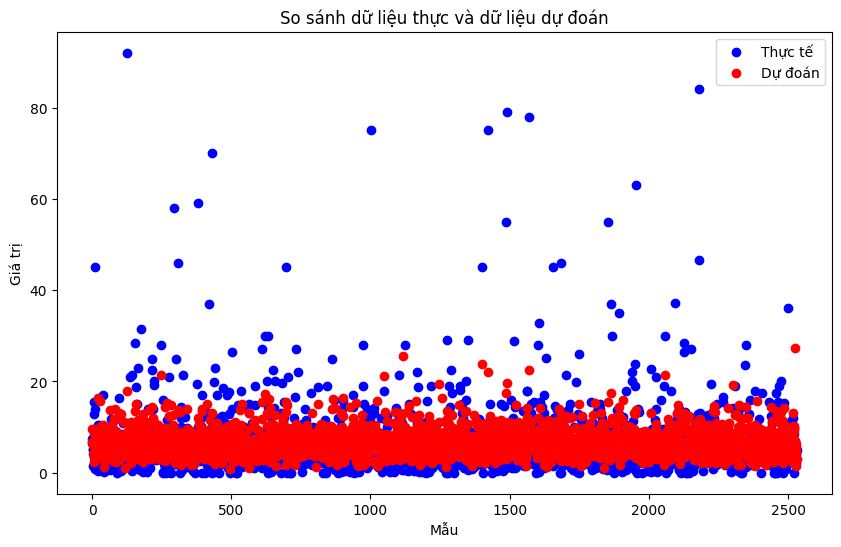

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Thực tế')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Dự đoán')
plt.xlabel('Mẫu')
plt.ylabel('Giá trị')
plt.title('So sánh dữ liệu thực và dữ liệu dự đoán')
plt.legend()
plt.show()

## **Random forest**

Random Forest là một thuật học tổng hợp (Ensemble learning), mà trong đấy sẽ xây dụng hàng loạt cây quyết định bằng cách cải tiến các kỹ thuật Bootstrapping và Bagging.

Bootstrapping là một kỹ thuật thống kê từ 1 bộ dữ liệu N sinh ra B bộ dữ liệu mới, các mẫu được lấy ra từ dataset một cách ngẫu nhiên, cho phép một mẫu được xuất hiện nhiều hơn một lần.

Bagging sẽ fit các model trên các tập dư liệu lấy ra bằng kỹ thuật Bootstrapping và tính trung bình cộng kết quả dự đoán của các model đó nhằm kiếm được một model mới có variance thấp.

Bagging là một thuật học tổng hợp hiệu quả vì mỗi cây quyết định sẽ được fit với một tập train có một ít khác nhau và do đó kết quả cũng sẽ hơi khác nhau. Không giống như các mô hình cây quyết định thông thường, chẳng hạn như cây phân loại và hồi quy (CART), chúng thường rơi vào tình trạng quá khớp với tập dữ liệu huấn luyện. Bagging giúp cho mỗi cây trở nên khác biệt hơn, làm giảm phương sai và các dự đoán lỗi.

Tuy nhiên khác với Bagging, Random Forest thay vì chỉ lấy mẫu qua observation trong tập dữ liệu để sinh mẫu, ta sẽ lấy mẫu trên tất cả features và chỉ lấy ngẫu nhiên 1 tập con để xây dựng cây quyết định. Việc lấy mẫu trên các features giúp cho tất cả các cây không dùng cùng một lượng thông tin để đưa ra quyết định và do đó sẽ làm giảm mối tương quan giữa các cây khác nhau.

In [11]:
RF_model = RandomForestRegressor(n_estimators=275, random_state=42)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)
mse_randomForest = mean_squared_error(y_test, y_pred)
rmse_randomForest = np.sqrt(mse_randomForest)
R2_random = RF_model.score(X_test,y_test)
print("MSE:", mse_randomForest)
print("RMSE score for Random Forest: {:.4f}".format(rmse_randomForest))
print("R2-Score: ", R2_random)

MSE: 31.86980871967716
RMSE score for Random Forest: 5.6453
R2-Score:  0.3046774241239991


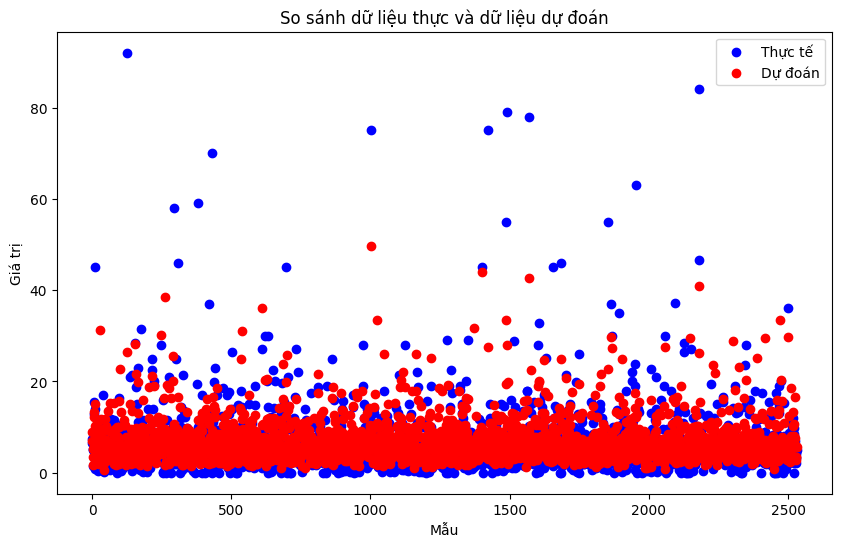

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Thực tế')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Dự đoán')
plt.xlabel('Mẫu')
plt.ylabel('Giá trị')
plt.title('So sánh dữ liệu thực và dữ liệu dự đoán')
plt.legend()
plt.show()

## **Support Vector Regression**



Support Vector Regression được sử dụng để dự đoán mối quan hệ phi tuyến giữa các biến. Nó sử dụng nguyên tắc của Support Vector Machine để xác định một hàm tuyến tính hoặc phi tuyến nhằm tối đa hóa khoảng cách giữa các điểm dữ liệu.

Điểm đặc biệt của SVR là khả năng làm việc với dữ liệu phi tuyến mà không yêu cầu giả định về phân phối và khả năng chống nhiễu. Để làm được điều này, SVR biến đổi dữ liệu huấn luyện thành không gian có số chiều cao hơn bằng cách sử dụng hàm kernel. Điều này cho phép mô hình nắm bắt được các mẫu và mối quan hệ phức tạp mà có thể không hiển nhiên trong không gian đặc trưng ban đầu.

Quá trình huấn luyện của SVR với mục đich tìm kiếm một hàm tuyến tính hoặc phi tuyến sao cho sai số dự đoán trên tập huấn luyện là nhỏ nhất. Để điều chỉnh độ phức tạp của mô hình, các tham số như hằng số điều chỉnh "C" và tham số "epsilon" được sử dụng để điều chỉnh độ mềm mại của ranh giới và sai số cho phép trong quá trình tối ưu hóa.

In [13]:
SVR_model = SVR(kernel='rbf')
SVR_model.fit(X_train, y_train)
y_pred = SVR_model.predict(X_test)
mse_SVR = mean_squared_error(y_test, y_pred)
rmse_SVR = np.sqrt(mse_SVR)
R2_SVR = SVR_model.score(X_test,y_test)
print("MSE:", mse_SVR)
print("RMSE score for Support Vector Regression: {:.4f}".format(rmse_SVR))
print("R2-Score: ", R2_SVR)

MSE: 41.94732718129542
RMSE score for Support Vector Regression: 6.4767
R2-Score:  0.0848102088292928


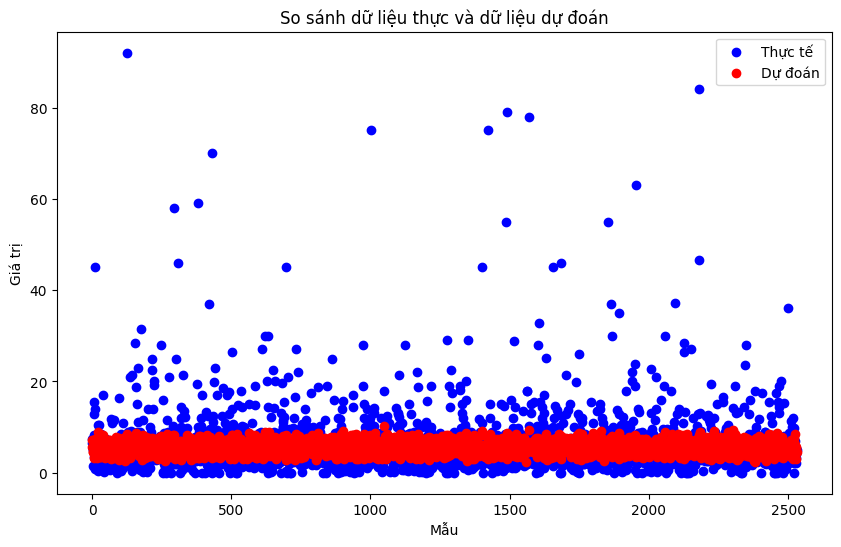

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Thực tế')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Dự đoán')
plt.xlabel('Mẫu')
plt.ylabel('Giá trị')
plt.title('So sánh dữ liệu thực và dữ liệu dự đoán')
plt.legend()
plt.show()

## **Gradient Boosting**

Gradient Boosting là một thuật toán học máy phổ biến và mạnh mẽ trong việc xử lý bộ dữ liệu bảng. Nó có khả năng tìm ra mối quan hệ phi tuyến giữa biến mục tiêu và các biến đầu vào một cách hiệu quả. Thuật toán này cũng linh hoạt trong việc xử lý các giá trị thiếu, giá trị ngoại lệ và biến có độ phân cấp cao mà không yêu cầu xử lý đặc biệt.

Trong Gradient Boosting, chúng ta xây dựng một chuỗi các cây quyết định yếu, gọi là các cây cơ bản. Mỗi cây cơ bản được xây dựng dựa trên việc điều chỉnh lỗi dự đoán của cây trước đó. Quá trình này được thực hiện bằng cách tối ưu hóa hàm mất mát, điều chỉnh các trọng số của các cây cơ bản để giảm thiểu sai số dự đoán.

Thuật toán Gradient Boosting sử dụng phương pháp tối ưu hóa gradient descent để điều chỉnh các trọng số của cây cơ bản. Phương pháp này tìm kiếm hướng giảm dốc tốt nhất của hàm mất mát trong không gian trọng số. Quá trình này được lặp đi lặp lại, mỗi vòng lặp tạo ra một cây cơ bản mới và cập nhật trọng số của chúng.

Một trong những điểm mạnh của Gradient Boosting là khả năng xử lý dữ liệu bảng phức tạp mà không yêu cầu tiền xử lý đặc biệt. Nó có thể làm việc với các biến số và biến phân loại, đồng thời xử lý các giá trị thiếu và giá trị ngoại lệ. Ngoài ra, Gradient Boosting còn có khả năng chống lại sự quá khớp và xây dựng các mô hình dự đoán chính xác.

In [15]:
GB_model = GradientBoostingRegressor(n_estimators=275, learning_rate=0.1, random_state=42)
GB_model.fit(X_train, y_train)
y_pred = GB_model.predict(X_test)
mse_GBoosting = mean_squared_error(y_test, y_pred)
rmse_GBoosting = np.sqrt(mse_GBoosting)
R2_GB = GB_model.score(X_test,y_test)
print("MSE:", mse_GBoosting)
print("RMSE score for GBoosting: {:.4f}".format(rmse_GBoosting))
print("R2-Score: ", R2_GB)

MSE: 32.016226168414505
RMSE score for GBoosting: 5.6583
R2-Score:  0.3014829475425821


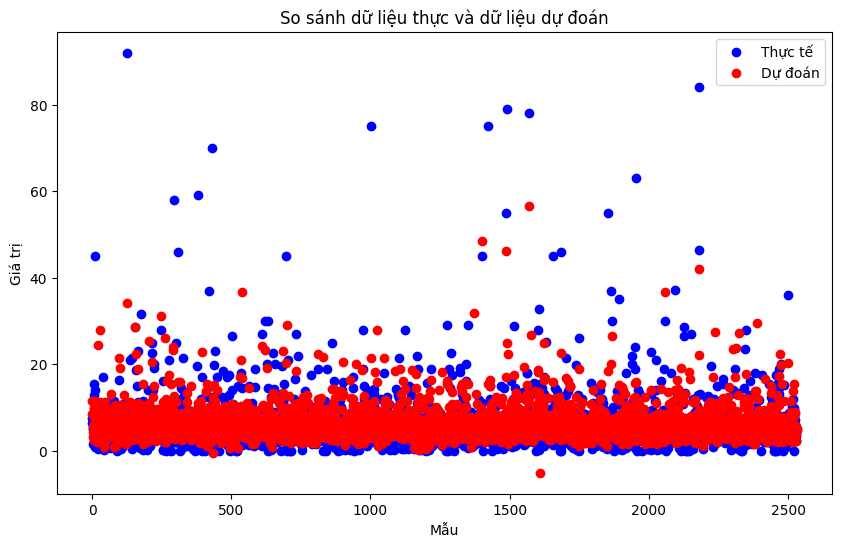

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Thực tế')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Dự đoán')
plt.xlabel('Mẫu')
plt.ylabel('Giá trị')
plt.title('So sánh dữ liệu thực và dữ liệu dự đoán')
plt.legend()
plt.show()

## **Neural Network**

Neural Network được thiết kế để mô phỏng cấu trúc và hoạt động của hệ thần kinh trong não người. Neural Network là một mô hình mạnh mẽ có khả năng xử lý dữ liệu phức tạp và giải quyết các bài toán dự đoán.

Ý tưởng chính của Neural Network là xây dựng một mạng lưới các "nút" ("neuron") nhân tạo, được tổ chức thành các "lớp" ("layer"). Mỗi nút nhận đầu vào từ các nút trong lớp trước đó và tính toán kết quả đầu ra dựa trên các trọng số và hàm kích hoạt. Quá trình tính toán này được thực hiện thông qua các kết nối trọng số giữa các nút.

Mạng Neural thường bao gồm một lớp đầu vào, một hoặc nhiều lớp ẩn và một lớp đầu ra. Các lớp ẩn giúp mô hình học được các đặc trưng phức tạp và tạo ra các biểu diễn của dữ liệu. Quá trình học của Neural Network thông qua việc điều chỉnh các trọng số, thường sử dụng phương pháp lan truyền ngược (backpropagation), để tối ưu hóa các thông số và đạt được dự đoán chính xác.

Neural Network có khả năng xử lý nhiều loại dữ liệu, bao gồm cả dữ liệu số và dữ liệu văn bản. Nó được áp dụng rộng rãi trong các lĩnh vực như nhận dạng hình ảnh, nhận dạng giọng nói, dịch máy, nhận dạng văn bản và nhiều ứng dụng khác liên quan đến xử lý ngôn ngữ tự nhiên.

In [17]:
NNR_model = MLPRegressor(hidden_layer_sizes=(200, 50), activation='tanh', solver='adam', random_state=42)
NNR_model.fit(X_train, y_train)
y_pred = NNR_model.predict(X_test)
mse_NNR = mean_squared_error(y_test, y_pred)
rmse_NNR = np.sqrt(mse_NNR)
R2_NNR = NNR_model.score(X_test,y_test)
print("MSE:", mse_NNR)
print("RMSE score for Neural Network Regressor: {:.4f}".format(rmse_NNR))
print("R2-Score: ", R2_NNR)

MSE: 40.28389865928277
RMSE score for Neural Network Regressor: 6.3470
R2-Score:  0.12110221845146929


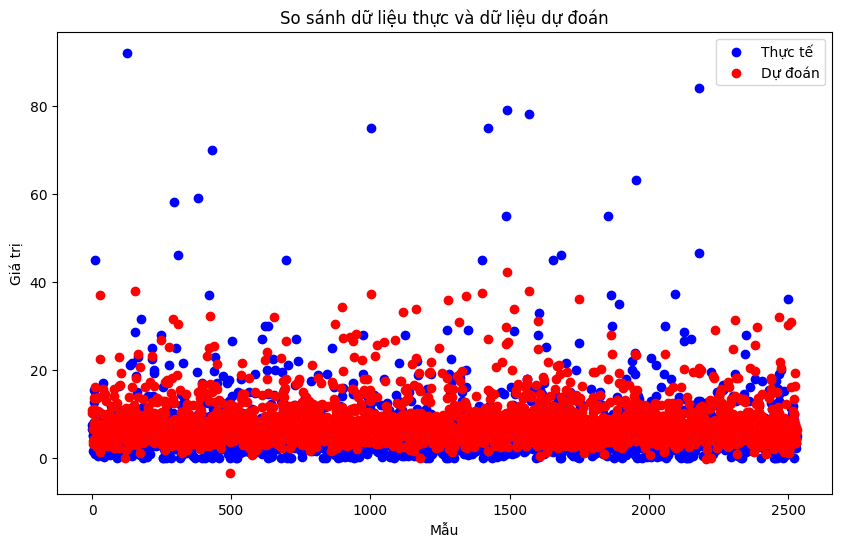

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Thực tế')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Dự đoán')
plt.xlabel('Mẫu')
plt.ylabel('Giá trị')
plt.title('So sánh dữ liệu thực và dữ liệu dự đoán')
plt.legend()
plt.show()

## **XGBoost - Extreme gradient boosting**

XGBoost là một biến thể của Gradient Boosting với hiệu suất cao và khả năng xử lý dữ liệu lớn.

Tương tự như Gradient Boosting, XGBoost xây dựng một chuỗi các cây quyết định nhằm giải quyết bài toán dự đoán. Mỗi cây trong chuỗi được xây dựng dựa trên việc sửa đổi lỗi dự đoán của cây trước đó. Tuy nhiên, XGBoost cung cấp nhiều cải tiến và tối ưu hóa để tăng cường hiệu suất và tốc độ huấn luyện.

Một trong những ưu điểm nổi bật của XGBoost là khả năng xử lý dữ liệu lớn một cách hiệu quả. Nó sử dụng các kỹ thuật như "column block" và "row block" để tận dụng tối đa khả năng tính toán của hệ thống phân tán và đa luồng.

XGBoost cũng cho phép tùy chỉnh và điều chỉnh mô hình theo nhiều cách. Bạn có thể tùy chỉnh hàm mất mát và phương pháp tối ưu hóa, điều chỉnh các tham số huấn luyện và kiểm soát quá khớp bằng cách sử dụng các biện pháp như ràng buộc L1 và L2.

Một điều cần lưu ý là thư viện này hỗ trợ cho việc train bằng GPU, cho nên tôi sẽ sử dụng nhằm có được tốc độ tốt hơn

In [21]:
Xgb_model =xgb.XGBRegressor(learning_rate=0.1, n_estimators=275,verbosity = 0,
                                               max_depth=3, min_child_weight=0,
                                               gamma=0, subsample=0.7,
                                               colsample_bytree=0.7,
                                               objective='reg:linear', nthread=4,
                                               scale_pos_weight=1, seed=27,
                                               reg_alpha=0.00006, device="cuda")
Xgb_model.fit(X_train, y_train)
Xgb_model.get_booster().feature_names = features
y_pred = Xgb_model.predict(X_test)
mse_XGBoost =  mean_squared_error(y_test, y_pred)
rmse_XGBoost = np.sqrt(mse_XGBoost)
R2_XGBoost = Xgb_model.score(X_test,y_test)
print("Mean Squared Error = {:.8f}".format(mse_XGBoost))
print("RMSE score for XGBoost: {:.4f}".format(rmse_XGBoost))
print("R2-Score: ", R2_XGBoost)

Mean Squared Error = 32.41659127
RMSE score for XGBoost: 5.6936
R2-Score:  0.29274794389256054


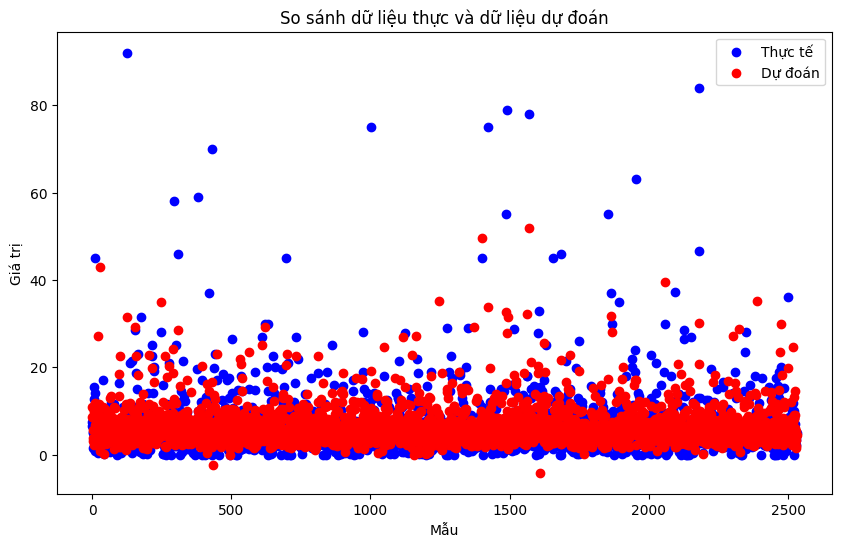

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Thực tế')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Dự đoán')
plt.xlabel('Mẫu')
plt.ylabel('Giá trị')
plt.title('So sánh dữ liệu thực và dữ liệu dự đoán')
plt.legend()
plt.show()

## **Stacking regression**


Stacking Regression kết hợp các mô hình hồi quy khác nhau để tạo ra dự đoán cuối cùng có độ chính xác cao hơn. Phương pháp này xây dựng một bộ sưu tập các mô hình hồi quy, được gọi là "bộ xếp chồng", và sử dụng dự đoán từ các mô hình này như các đặc trưng đầu vào cho một mô hình hồi quy cuối cùng, được gọi là "mô hình meta-regression".

Quá trình huấn luyện của Stacking Regression bao gồm hai giai đoạn. Trong giai đoạn đầu tiên, các mô hình hồi quy trong bộ xếp chồng được huấn luyện trên tập dữ liệu huấn luyện ban đầu. Sau đó, trong giai đoạn thứ hai, dự đoán từ các mô hình cơ sở được sử dụng làm đặc trưng đầu vào cho mô hình meta-regression, và mô hình này được huấn luyện trên tập dữ liệu huấn luyện ban đầu.

Stacking Regression có thể được mở rộng để xử lý nhiều cấp độ của bộ xếp chồng và mô hình meta-regression, tạo ra một cấu trúc phân cấp linh hoạt. Điều này cho phép việc kết hợp các mô hình dự đoán ở nhiều mức độ khác nhau và tăng cường khả năng dự đoán của phương pháp.

In [23]:
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)
gboost_model = GradientBoostingRegressor(n_estimators=275, learning_rate=0.1, random_state=42)
gboost_model.fit(X_train, y_train)
xgb_model =xgb.XGBRegressor(learning_rate=0.01, n_estimators=275,verbosity = 0,
                                               max_depth=3, min_child_weight=0,
                                               gamma=0, subsample=0.7,
                                               colsample_bytree=0.7,
                                               objective='reg:linear', nthread=4,
                                               scale_pos_weight=1, seed=27,
                                               reg_alpha=0.00006, device="cuda")
xgb_model.fit(X_train, y_train)
stack_regressor = StackingCVRegressor(regressors=(RF_model, gboost_model, xgb_model), meta_regressor=xgb_model, use_features_in_secondary=True)
stack_model = stack_regressor.fit(X_train, y_train)
stack_preds = stack_model.predict(X_test)
mse_stackRegressor = mean_squared_error(y_test, stack_preds)
rmse_stackRegressor = np.sqrt(mse_stackRegressor)
print("MSE:", mse_stackRegressor)
print("RMSE score for XGBoost: {:.4f}".format(rmse_stackRegressor))
R2_stack = stack_model.score(X_train, y_train)
print("R2-Score: ", R2_stack)

MSE: 30.48313070778491
RMSE score for XGBoost: 5.5212
R2-Score:  0.6003641018506951


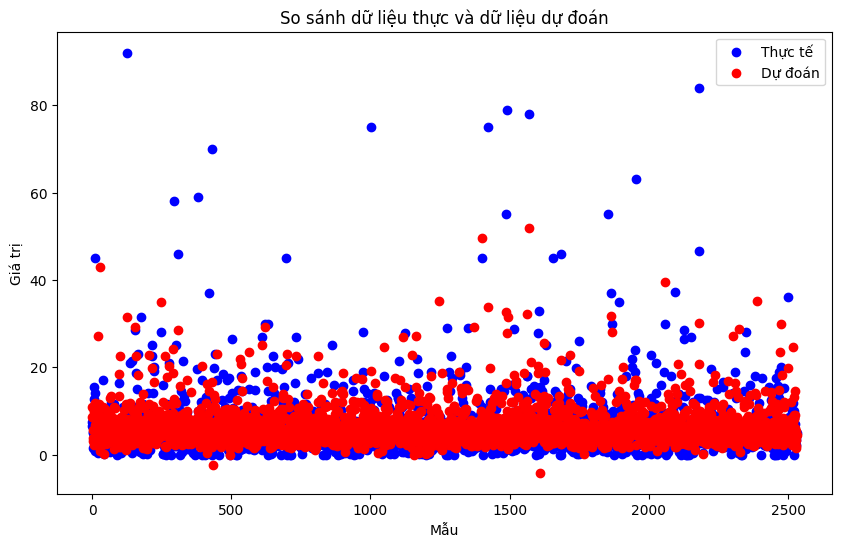

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Thực tế')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Dự đoán')
plt.xlabel('Mẫu')
plt.ylabel('Giá trị')
plt.title('So sánh dữ liệu thực và dữ liệu dự đoán')
plt.legend()
plt.show()

## **Tính RMSE với cross validation**

In [25]:
def rmse_kfold(model, n_folds):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(np.mean(rmse))

In [26]:
# Giá trị MSE của các mô hình
mse_values = [ mse_SVR, mse_randomForest, mse_NNR, mse_XGBoost, mse_GBoosting, mse_linearRegression, mse_lassoRegression,mse_stackRegressor]

# Giá trị RMSE của các mô hình
rmse_values = [ rmse_SVR, rmse_randomForest, rmse_NNR, rmse_XGBoost, rmse_GBoosting, rmse_linearRegression, rmse_lassoRegression,rmse_stackRegressor]

r2_values = [R2_SVR, R2_random, R2_NNR, R2_XGBoost, R2_GB, R2_linear, R2_lasso,R2_stack]
# Tên của các mô hình
models_name = [ 'SVR', 'Random Forest', 'Neural Network Regression', 'XGBoost','Gradient Boosting', 'Linear', 'Lasso', 'Stack']
models = [SVR_model, RF_model, NNR_model, xgb_model, GB_model, linear_model ,lasso_model , stack_model]
rmse_values_kfold = []
for model in models:
    rmse_values_kfold.append(rmse_kfold(model,5))

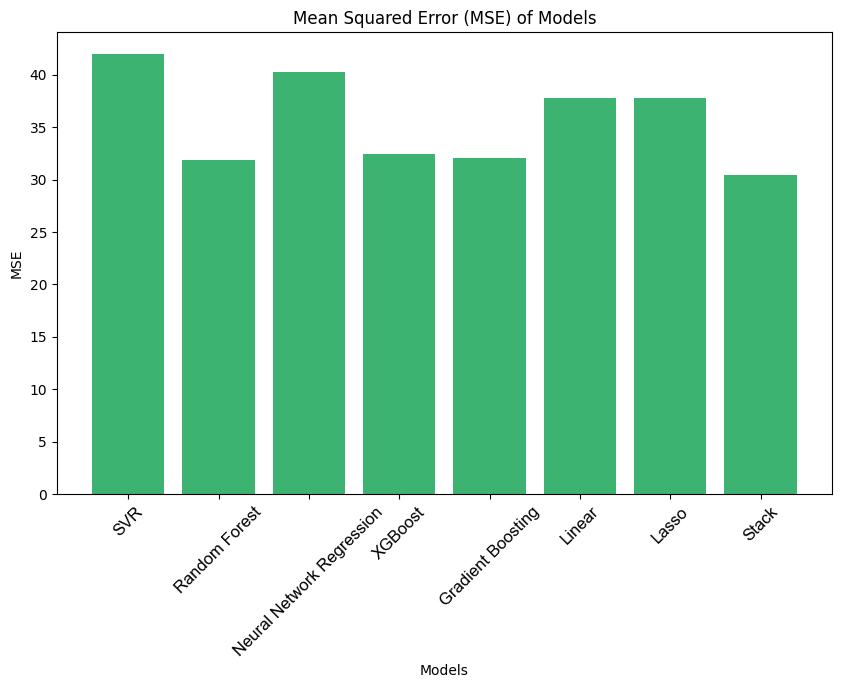

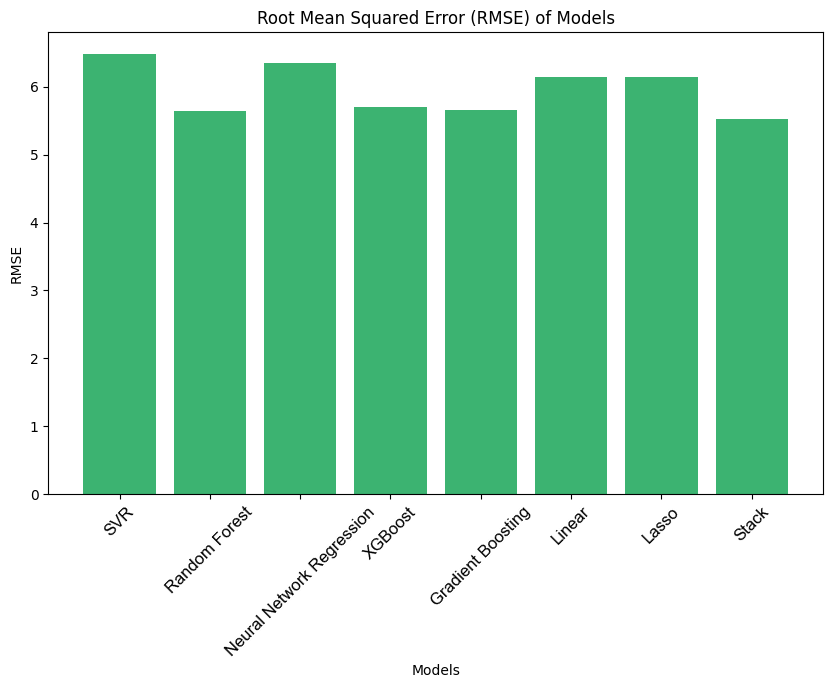

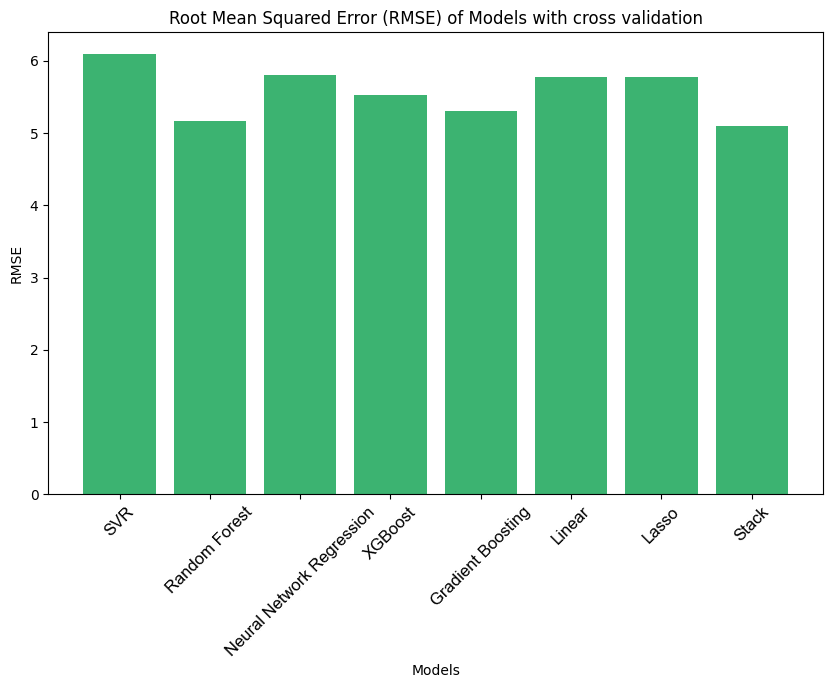

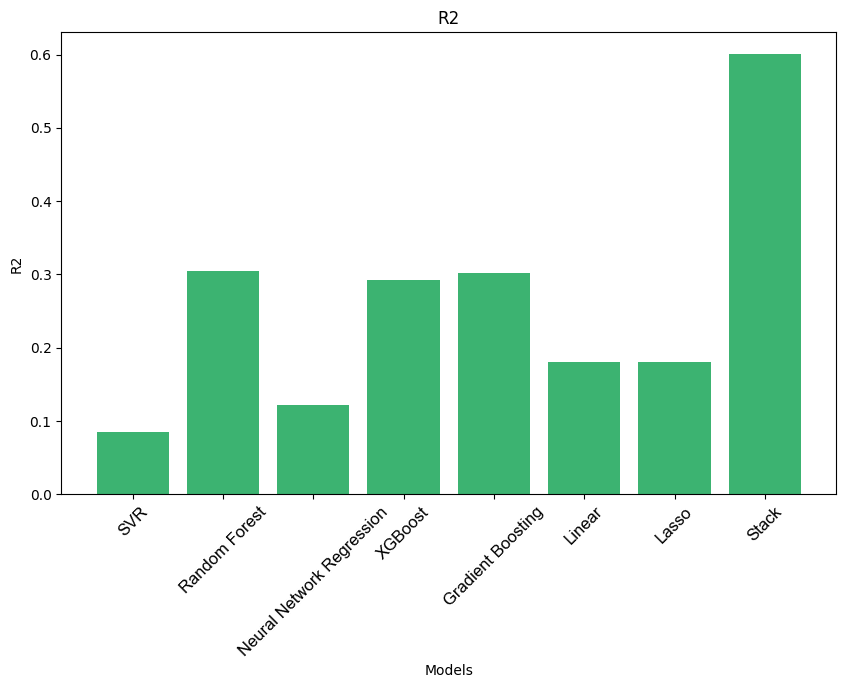

In [27]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(models_name, mse_values, color = 'mediumseagreen')
plt.title('Mean Squared Error (MSE) of Models')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.xticks(fontname='Arial', fontsize=12)
plt.show()

# Vẽ đồ thị RMSE
plt.figure(figsize=(10, 6))
plt.bar(models_name, rmse_values, color = 'mediumseagreen')
plt.title('Root Mean Squared Error (RMSE) of Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.xticks(fontname='Arial', fontsize=12)
plt.show()

# Vẽ đồ thị RMSE với cross validation kfold = 5
plt.figure(figsize=(10, 6))
plt.bar(models_name, rmse_values_kfold, color = 'mediumseagreen')
plt.title('Root Mean Squared Error (RMSE) of Models with cross validation')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.xticks(fontname='Arial', fontsize=12)
plt.show()

# Vẽ đồ thị R2
plt.figure(figsize=(10, 6))
plt.bar(models_name, r2_values, color = 'mediumseagreen')
plt.title('R2')
plt.xlabel('Models')
plt.ylabel('R2')
plt.xticks(rotation=45)
plt.xticks(fontname='Arial', fontsize=12)
plt.show()

Độ quan trọng của các feature trong 2 model Gradient boosting và Extreme gradient boosting

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

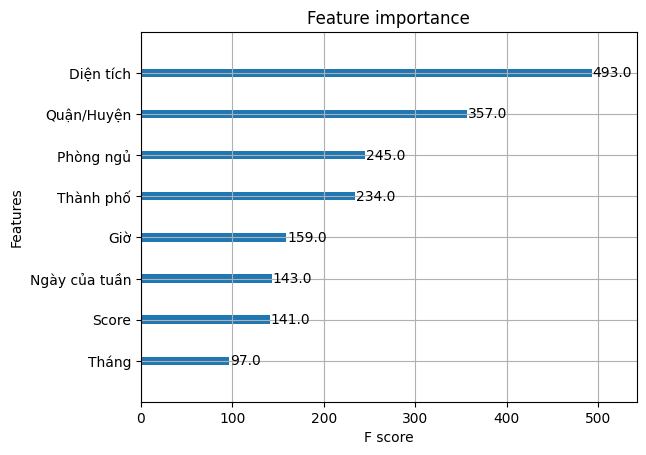

In [28]:
xgb.plot_importance(Xgb_model)

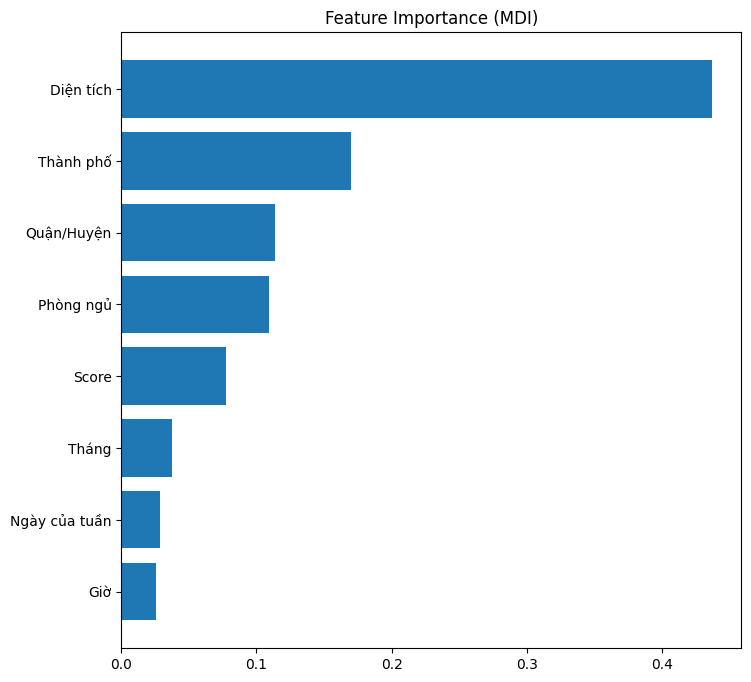

In [29]:
feature_importance = GB_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()

Mse trên từng từng iteration của Gradient boosting

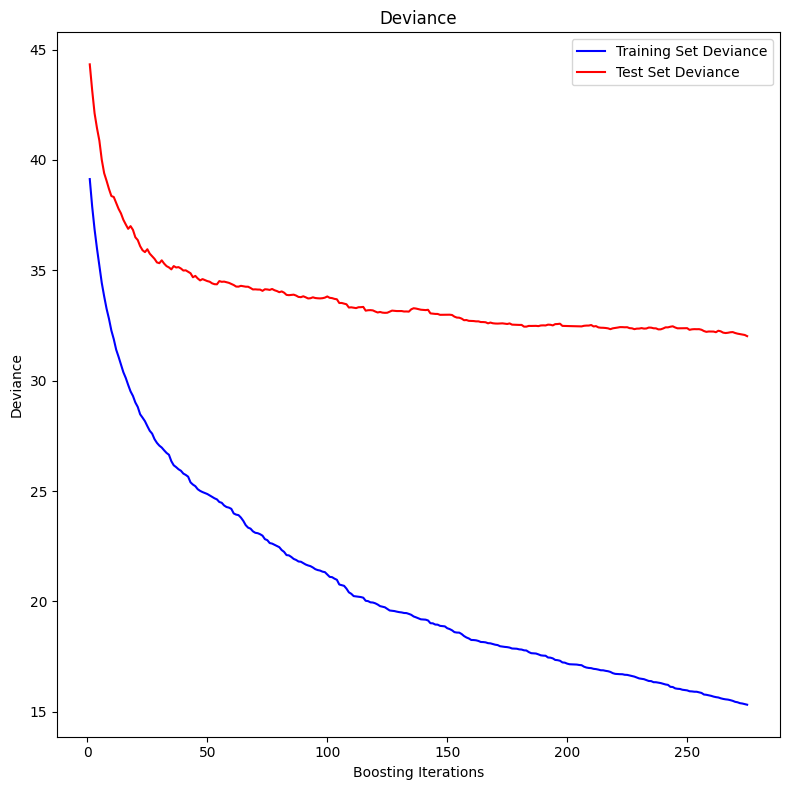

In [30]:
test_score = np.zeros((GB_model.get_params()['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(GB_model.staged_predict(X_test)):
    test_score[i] =mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(8, 8))
plt.title('Deviance')
plt.plot(np.arange(GB_model.get_params()['n_estimators']) + 1, GB_model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(GB_model.get_params()['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

# **Tổng kết**
Tổng quan ta thấy Stacked Generalization là thuật toán nổi trội nhất do sử dụng các thuật toán mạnh mẽ khác làm base. Tuy nhiên thời gian của stack do đó cũng cao hơn hẳn so với các thuật toán khác.

Tiếp theo, randomforest thật sự hiệu qua cho dự liệu phi tuyến tính nhưng vấn đề vẫn là thời gian, cùng việc xác định sao cho hợp lý nhất các số lượng estimators.

Tiếp đến, là 2 thuật toán sử dụng boosting là Gradient boosting regressor và Extrame gradient boosting. Mặc dù vận kết quả cho thấy Gradient boosting regressor. Nhưng so vo về tốc độ cũng nhưng thứ khác đi kèm với Extrame gradient boosting trong thư viện xgboost là tốt hơn.
Mạng Neural cũng được sử dụng nhưng có do còn ít nút, lớp nên chưa phát huy sức mạnh model

Hồi quy linear và lasso thì hoạt động kém trong dữ liệu phi tuyến.

Hồi quy sử support vectot kém nhất khi dữ liệu khá lớn, lại chứa nhiều outlier.
